In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping



In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224  # Updated for VGG19 compatibility
CHANNELS = 3
EPOCHS = 20

In [3]:
# Load the dataset
dataset = image_dataset_from_directory(
    "C:/Users/ella/Desktop/2nd year 2nd semester/machine learning/leaf disease dataset/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


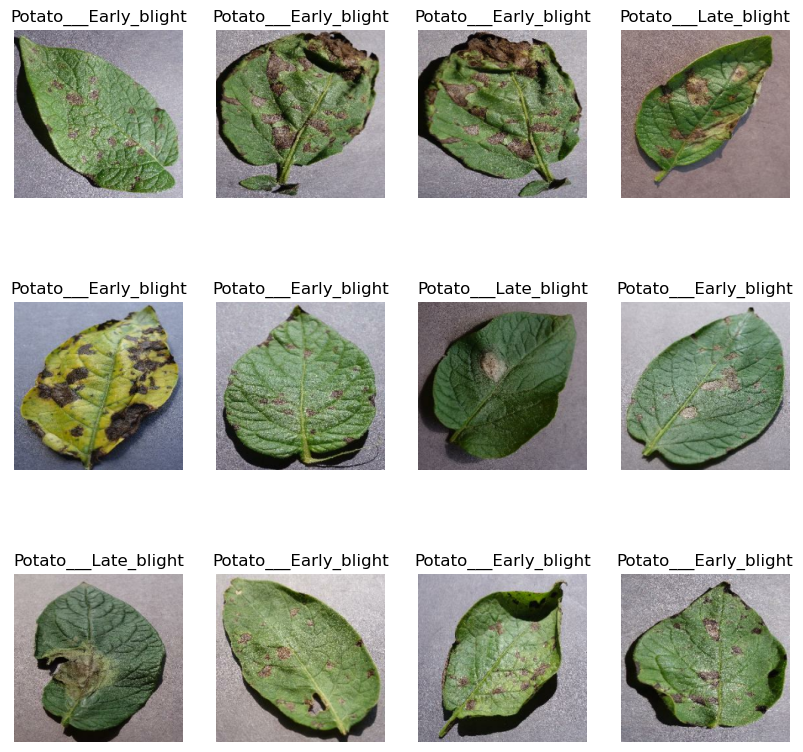

In [6]:
# Plot some sample images
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

C:\Users\ella\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [13]:
n_classes = len(class_names)

In [14]:
base_model = VGG19(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')
base_model.trainable = False



In [15]:
model = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,025,923 (76.39 MB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1147s 21s/step - accuracy: 0.5286 - loss: 0.9056 - val_accuracy: 0.7500 - val_loss: 0.7820
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 385s 7s/step - accuracy: 0.6610 - loss: 0.8073 - val_accuracy: 0.8333 - val_loss: 0.6879
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 488s 8s/step - accuracy: 0.7452 - loss: 0.7252 - val_accuracy: 0.8490 - val_loss: 0.6239
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 449s 8s/step - accuracy: 0.8019 - loss: 0.6183 - val_accuracy: 0.8698 - val_loss: 0.5695
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 454s 8s/step - accuracy: 0.8310 - loss: 0.5681 - val_accuracy: 0.8802 - val_loss: 0.5231
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 429s 8s/step - accuracy: 0.8343 - loss: 0.5370 - val_accuracy: 0.8594 - val_loss: 0.5024
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 461s 9s/step - accuracy: 0.8325 - loss: 0.5225 - val_accuracy: 0.8802 - val_loss: 0.4620
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 436s 8s/step - accuracy: 0.8517 - loss: 0.4761 - val_accuracy: 0.8906 -

In [19]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 208s 25s/step - accuracy: 0.9027 - loss: 0.3405


In [20]:
print(f"Test Accuracy: {scores[1] * 100:.2f}%")


Test Accuracy: 91.02%


In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


In [36]:
import netron

In [37]:
model.save('model.keras')

In [38]:
netron.start('model.keras')

Serving 'model.keras' at http://localhost:8080


('localhost', 8080)

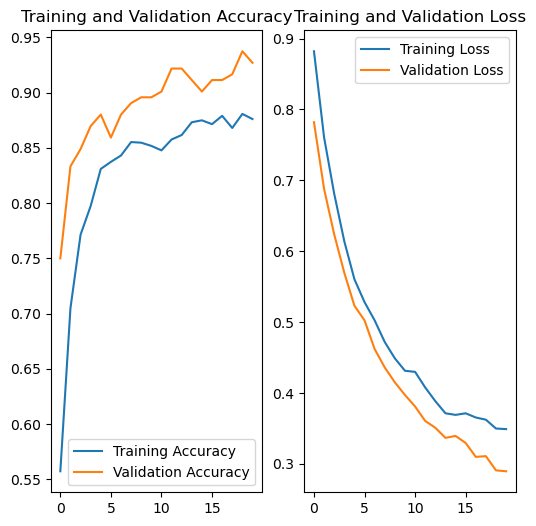

In [41]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step
Predicted label: Potato___Early_blight


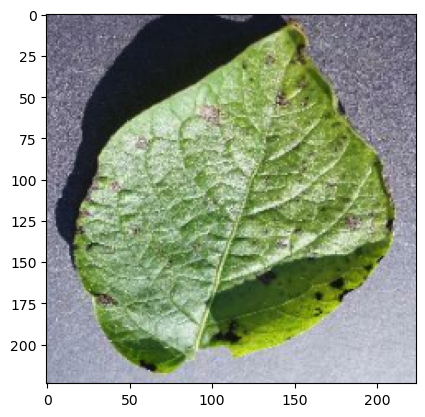

In [23]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


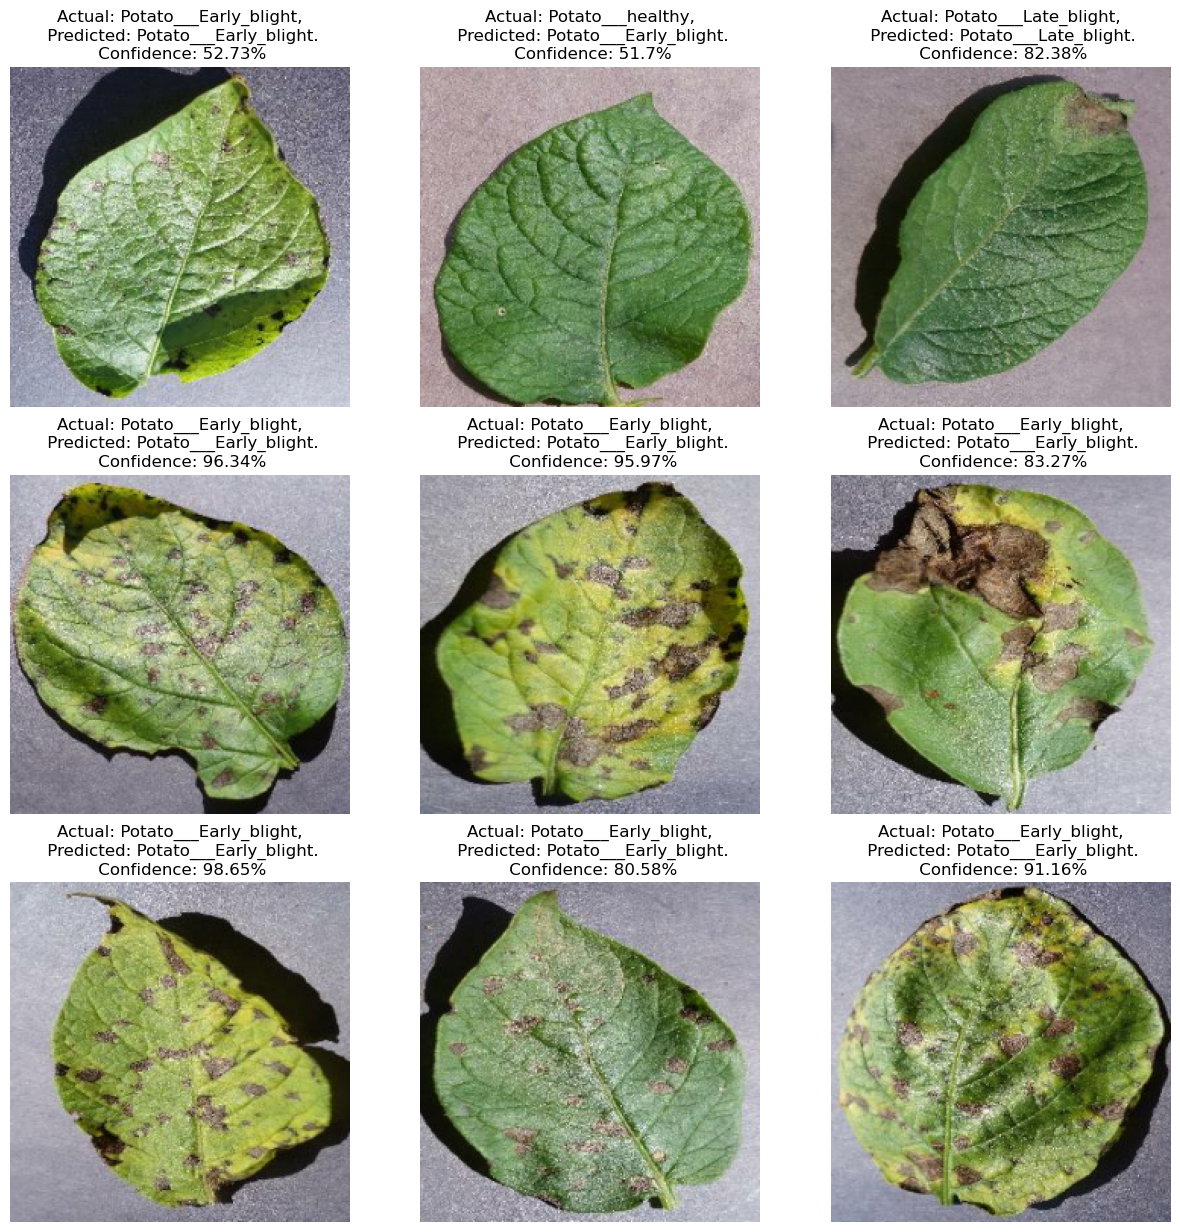

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
        plt.savefig('plot3.png')

In [28]:
y_true = []
y_pred = []

In [29]:
for images_batch, labels_batch in test_ds:
    predictions = model.predict(images_batch)
    y_true.extend(labels_batch.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

<Figure size 1500x1500 with 0 Axes>

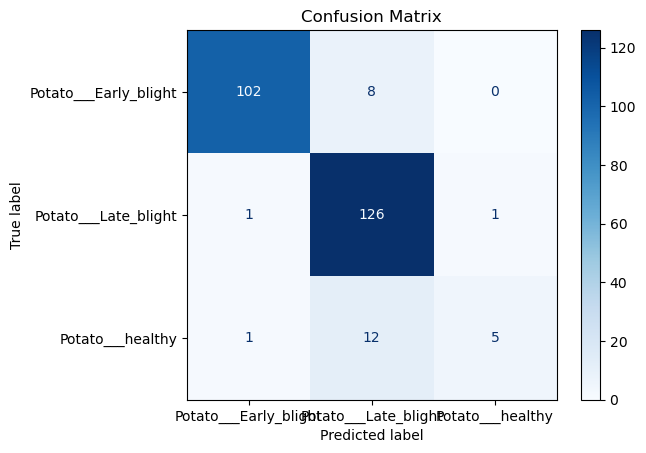

<Figure size 640x480 with 0 Axes>

In [34]:
plt.figure(figsize=(15, 15))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
plt.savefig('plot4.png')